In [58]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

from ROOT import TFile, TTree, TChain
from ROOT import TH1F, TCanvas

import os
import sys
sys.path.insert(0, os.path.abspath('/home/arsahasransu/Documents/SoftDisplacedLeptons/Classifier/'))

print("All classes initialized successfully!!!")

All classes initialized successfully!!!


In [2]:
import plotBeautifier as pB

In [3]:
pB.trial_func("AR")

Trial works fine. Hello,AR


In [25]:
sigChan = TChain("varTree")
sigChan.Add("../signal_BP_200_220_2cm_DNN.root")
sigChan2 = TChain("varTree")
sigChan2.Add("../signal_BP_180_220_2cm_DNN.root")
sigChan3 = TChain("varTree")
sigChan3.Add("../signal_BP_200_220_DM_DNN.root")
sigChanTrain = TChain("varTree")
sigChanTrain.Add("../signal_DNN.root")
bkgChan = TChain("varTree")
bkgChan.Add("../background_DNN.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [26]:
sigChan.Print()
sigChan2.Print()
sigChan3.Print()
sigChanTrain.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : ../signal_BP_200_220_2cm_DNN.root                      *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    19758 : Total =         1431139 bytes  File  Size =    1214718 *
*        :          : Tree compression factor =   1.18                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    19758 : Total  Size=     158932 bytes  File Size  =      10397 *
*Baskets :        5 : Basket Size=      32000 bytes  Compression=  15.24     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [50]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
sig2SampleSize = sigChan2.GetEntries()
sig3SampleSize = sigChan3.GetEntries()
sigTrainSampleSize = sigChanTrain.GetEntries()
bkgSampleSize = bkgChan.GetEntries()

# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
sigFull2 = sigChan2.AsMatrix()
sigFull2 = sigFull2[1:10000]
sigFull3 = sigChan3.AsMatrix()
sigFull3 = sigFull3[2500:]
sigTrainFull = sigChanTrain.AsMatrix()
bkgFull = bkgChan.AsMatrix()

print(sigFull.shape)
print(sigFull2.shape)
print(sigFull3.shape)
print(sigTrainFull.shape)
print(bkgFull.shape)

(19758, 9)
(9999, 9)
(16756, 9)
(44440, 9)
(4108, 9)


In [51]:
# Load the input data scaler
scaler = joblib.load("./scaler.save")

# Load the model
loaded_model = m.load_model("./simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Predict on the samples
sigScaled = scaler.transform(sigFull)
sigScaled2 = scaler.transform(sigFull2)
sigScaled3 = scaler.transform(sigFull3)
sigTrainScaled = scaler.transform(sigTrainFull)
bkgScaled = scaler.transform(bkgFull)

sigPredict = loaded_model.predict(sigScaled)
sigPredict2 = loaded_model.predict(sigScaled2)
sigPredict3 = loaded_model.predict(sigScaled3)
sigTrainPredict = loaded_model.predict(sigTrainScaled)
bkgPredict = loaded_model.predict(bkgScaled)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [33]:
print(sigTrainPredict[0:5])

[[0.8068562  0.1931438 ]
 [0.30050308 0.6994969 ]
 [0.9924694  0.00753069]
 [0.3303033  0.66969675]
 [0.982544   0.01745597]]


In [34]:
print(np.array(sigTrainPredict)[0:5,0])

[0.8068562  0.30050308 0.9924694  0.3303033  0.982544  ]


Discriminator plotted!!!


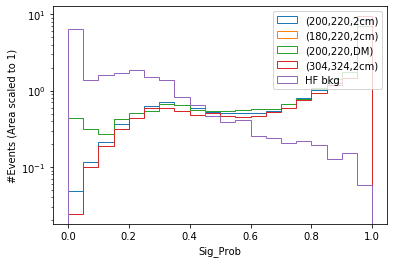

In [35]:
# Discriminator shape
plt.clf()
plt.yscale('log')
plt.hist(np.array(sigPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='(200,220,2cm)')
plt.hist(np.array(sigPredict2)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='(180,220,2cm)')
plt.hist(np.array(sigPredict3)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='(200,220,DM)')
plt.hist(np.array(sigTrainPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='(304,324,2cm)')
plt.hist(np.array(bkgPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='HF bkg')
plt.xlabel("Sig_Prob")
plt.ylabel("#Events (Area scaled to 1)")
plt.legend()
plt.savefig("Discriminator.pdf")
print("Discriminator plotted!!!")

In [36]:
# Discriminator Shape in ROOT plotting
c1 = TCanvas()
nBins = 100
sigTrainHisto = TH1F("","",nBins,0,1)
sigHisto = TH1F("","",nBins,0,1)
sig2Histo = TH1F("","",nBins,0,1)
sig3Histo = TH1F("","",nBins,0,1)
bkgHisto = TH1F("","",nBins,0,1)
sigTrainHisto.FillN(sigTrainPredict.shape[0],(sigTrainPredict[:,0]).astype(float),np.ones(sigTrainPredict.shape[0]))
sigHisto.FillN(sigPredict.shape[0],(sigPredict[:,0]).astype(float),np.ones(sigPredict.shape[0]))
sig2Histo.FillN(sigPredict2.shape[0],(sigPredict2[:,0]).astype(float),np.ones(sigPredict2.shape[0]))
sig3Histo.FillN(sigPredict3.shape[0],(sigPredict3[:,0]).astype(float),np.ones(sigPredict3.shape[0]))
bkgHisto.FillN(bkgPredict.shape[0],(bkgPredict[:,0]).astype(float),np.ones(bkgPredict.shape[0]))

In [37]:
# Using plotBeautifier

histList = [sigTrainHisto, sigHisto, sig2Histo, sig3Histo, bkgHisto]
labelList = ["(304,324,2cm)", "(200,220,2cm)", "(180,220,2cm)", "(200,220,DM)", "HF Background"]
xAxisTitle = "Sig_Prob"
yAxisTitle = "# Events (scaled to 1)"
outPlotName = "Discriminator_Beautified"
pB.plotBeautifier(histList, labelList, xAxisTitle, yAxisTitle, outPlotName)

Created a canvas
1
2
3
4
5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Discriminator_Beautified.pdf has been created


In [38]:
type((sigTrainPredict[:,0]).astype(float))

numpy.ndarray

In [39]:
# For plots based on discriminator cut

sigProb = np.arange(0, 1, 0.001) 
sigPredictSigProb = np.array(sigPredict)[:,0] 
sig2PredictSigProb = np.array(sigPredict2)[:,0] 
sig3PredictSigProb = np.array(sigPredict3)[:,0] 
sigTrainPredictSigProb = np.array(sigTrainPredict)[:,0] 
bkgPredictSigProb = np.array(bkgPredict)[:,0]

tpr = [] 
fpr = []
tpr2 = [] 
fpr2 = []
tpr3 = [] 
fpr3 = []
tprTrain = [] 
fprTrain = []

for x in sigProb: 
    sigPredictClass = sigPredictSigProb>x 
    sig2PredictClass = sig2PredictSigProb>x 
    sig3PredictClass = sig3PredictSigProb>x 
    sigTrainPredictClass = sigTrainPredictSigProb>x
    bkgPredictClass = bkgPredictSigProb>x
    
    tp1 = sigPredictClass.sum()
    fn1 = (1-sigPredictClass).sum()
    tn1 = (1-bkgPredictClass).sum()
    fp1 = bkgPredictClass.sum()
    tpr.append(tp1/(tp1+fn1))
    fpr.append(fp1/(fp1+tn1))

    tp3 = sig2PredictClass.sum()
    fn3 = (1-sig2PredictClass).sum()
    tn3 = (1-bkgPredictClass).sum()
    fp3 = bkgPredictClass.sum()
    tpr2.append(tp3/(tp3+fn3))
    fpr2.append(fp3/(fp3+tn3))

    tp4 = sig3PredictClass.sum()
    fn4 = (1-sig3PredictClass).sum()
    tn4 = (1-bkgPredictClass).sum()
    fp4 = bkgPredictClass.sum()
    tpr3.append(tp4/(tp4+fn4))
    fpr3.append(fp4/(fp4+tn4))

    tp2 = sigTrainPredictClass.sum()
    fn2 = (1-sigTrainPredictClass).sum()
    tn2 = (1-bkgPredictClass).sum()
    fp2 = bkgPredictClass.sum()
    tprTrain.append(tp2/(tp2+fn2))
    fprTrain.append(fp2/(fp2+tn2))

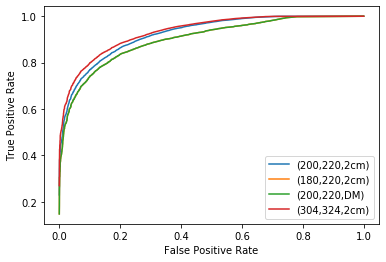

In [40]:
# ROC Curve

plt.clf()
plt.plot(fpr,tpr, label="(200,220,2cm)")
plt.plot(fpr2,tpr2, label="(180,220,2cm)")
plt.plot(fpr3,tpr3, label="(200,220,DM)")
plt.plot(fprTrain,tprTrain, label="(304,324,2cm)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.xscale('log')
plt.legend()
plt.savefig("roc.pdf")

In [17]:
# Factor to calculate the disciminator cut
# Aim to reduce the number of background events to before the PT interpolation
# 0.95CL Kappa Factor = 1288.4
# No. of bkg events surviving the disc cut = 4108/1288.4
bkgSurv = 4108/1288.4
print(bkgSurv)

3.1884507916796023


In [18]:
x = 0.98
bkgPredictSigProb = np.array(bkgPredict)[:,0]
bkgPredictClass = bkgPredictSigProb>x

print(bkgPredictClass.sum())

3


In [19]:
sigPredictSigProb = np.array(sigPredict)[:,0] 
sig2PredictSigProb = np.array(sigPredict2)[:,0] 
sig3PredictSigProb = np.array(sigPredict3)[:,0] 
sigTrainPredictSigProb = np.array(sigTrainPredict)[:,0] 

sigPredictClass = sigPredictSigProb>x 
sig2PredictClass = sig2PredictSigProb>x 
sig3PredictClass = sig3PredictSigProb>x 
sigTrainPredictClass = sigTrainPredictSigProb>x

print(sigPredictClass.sum())
print(sig2PredictClass.sum())
print(sig3PredictClass.sum())
print(sigTrainPredictClass.sum())

6996
2758
544
17673


In [21]:
6996.0/19758

0.35408442150015185

In [22]:
2758/9999.0

0.27582758275827585

In [23]:
544/1793.0

0.3034021193530396

In [24]:
17673/44440.0

0.3976822682268227

In [53]:
sigXsec = 902.57
sig2Xsec = 902.57
sig3Xsec = 100
sigTrainXsec = 127.641

Lumi = 2.6

N = Lumi*sigXsec
N2 = Lumi*sig2Xsec
N3 = Lumi*sig3Xsec
NTrain = Lumi*sigTrainXsec

print(N, N2, N3, NTrain)

2346.6820000000002 2346.6820000000002 260.0 331.8666


In [59]:
def sig(s,b):
    return s/math.sqrt(s+b)

In [60]:
sig(2346.68,4122.8)

29.175558924024354